In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
style_1 = [
     {'selector':"th", 
     'props':[('background-color', 'darkblue'),
               ('color', 'white'),
               ('font-weight','bold'),
               ("border-collapse", "collapse"),
               ('text-transform', 'uppercase'),
               ('border', '0.5px solid white') 
               ]},
    {'selector': 'td',
     'props': [('background-color', 'blue'),
               ('color', 'white'),
               ('font-weight','light'),
               ('text-transform', 'uppercase'),
               ('border', '0.5px solid white')]},
    
    {'selector': 'caption',
     'props': [('color', 'black'),
               ('font-size', '30px')]}
]


style_2 = [
    {'selector':"th", 
     'props':[ ("color", "#fff"),
               ("padding", "12px 35px"),
               ("border-collapse", "collapse"),
               ("background", "#00cccc"),
               ("text-transform", "uppercase"),
               ("font-size", "12px")
               ]},
    
    {'selector': 'td',
     'props': [('text-transform', 'uppercase'),
               ('border', '0.5px solid white')]},
    
    {'selector': 'caption',
     'props': [('color', 'black'),
               ('font-size', '25px')]}
]

def display(df_table, caption="", style=style_2):
    return df_table.style.set_table_styles(style).set_caption(caption.upper()).hide_index()

In [3]:
#Libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import holidays
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
FILEPATH='../input/playground-series-s3e19'
df_train=pd.read_csv(os.path.join(FILEPATH,'train.csv'))
df_submission=pd.read_csv(os.path.join(FILEPATH,'sample_submission.csv'))
df_train['date'] = pd.to_datetime(df_train['date'])
df_test=pd.read_csv(os.path.join(FILEPATH,'test.csv'))
df_test['date']=pd.to_datetime(df_test['date'])

cols=df_train.columns.tolist()
target_col='num_sold '
cat_cols=df_train.select_dtypes(include='object')
num_cols=df_train.select_dtypes(include='int64')

In [5]:
display(pd.DataFrame(df_train.isna().sum()+df_test.isna().sum()).transpose(),'sparsity')

In [6]:
display(df_train.head(),'header')

In [7]:
display(df_train.describe().iloc[:,1].to_frame().transpose(),'stats_sale',style_1)

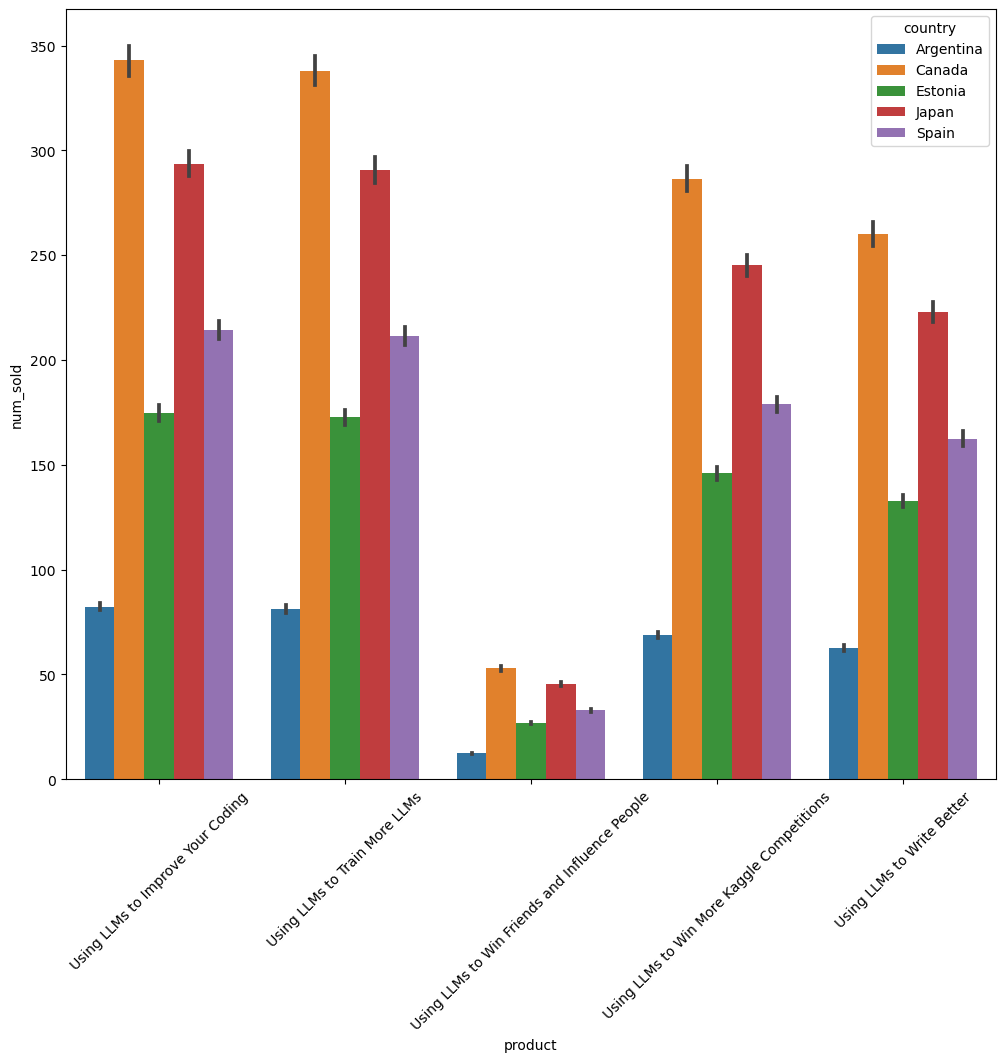

In [8]:
#A plot for visualising sales of each product in each country.
plt.figure(figsize = (12, 10))
ax = sns.barplot(data = df_train, x = 'product', y = 'num_sold', hue = 'country')
plt.xticks(rotation = 45);

#Argentina got least sales
#Canada got the most sales
#The most sold product is 'USING LLM TO IMPROVE CODING'

<Figure size 500x2000 with 0 Axes>

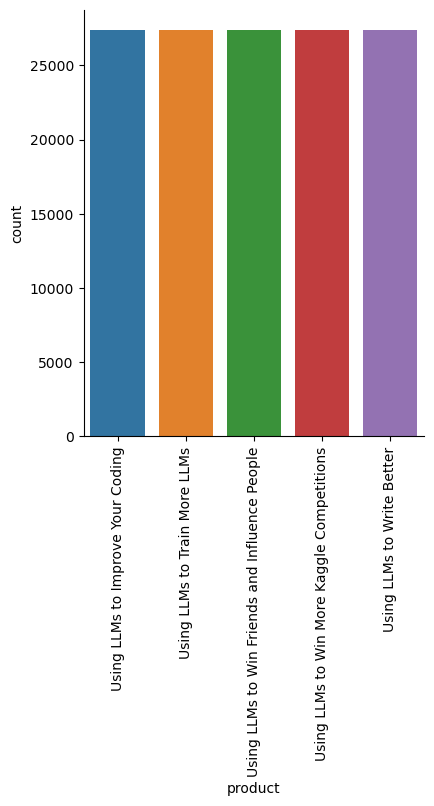

In [9]:
plt.figure(figsize=(5,20))
ax=sns.catplot(data=df_train,x='product',kind='count')
plt.xticks(rotation =90);
#The dataset is balanced for each product

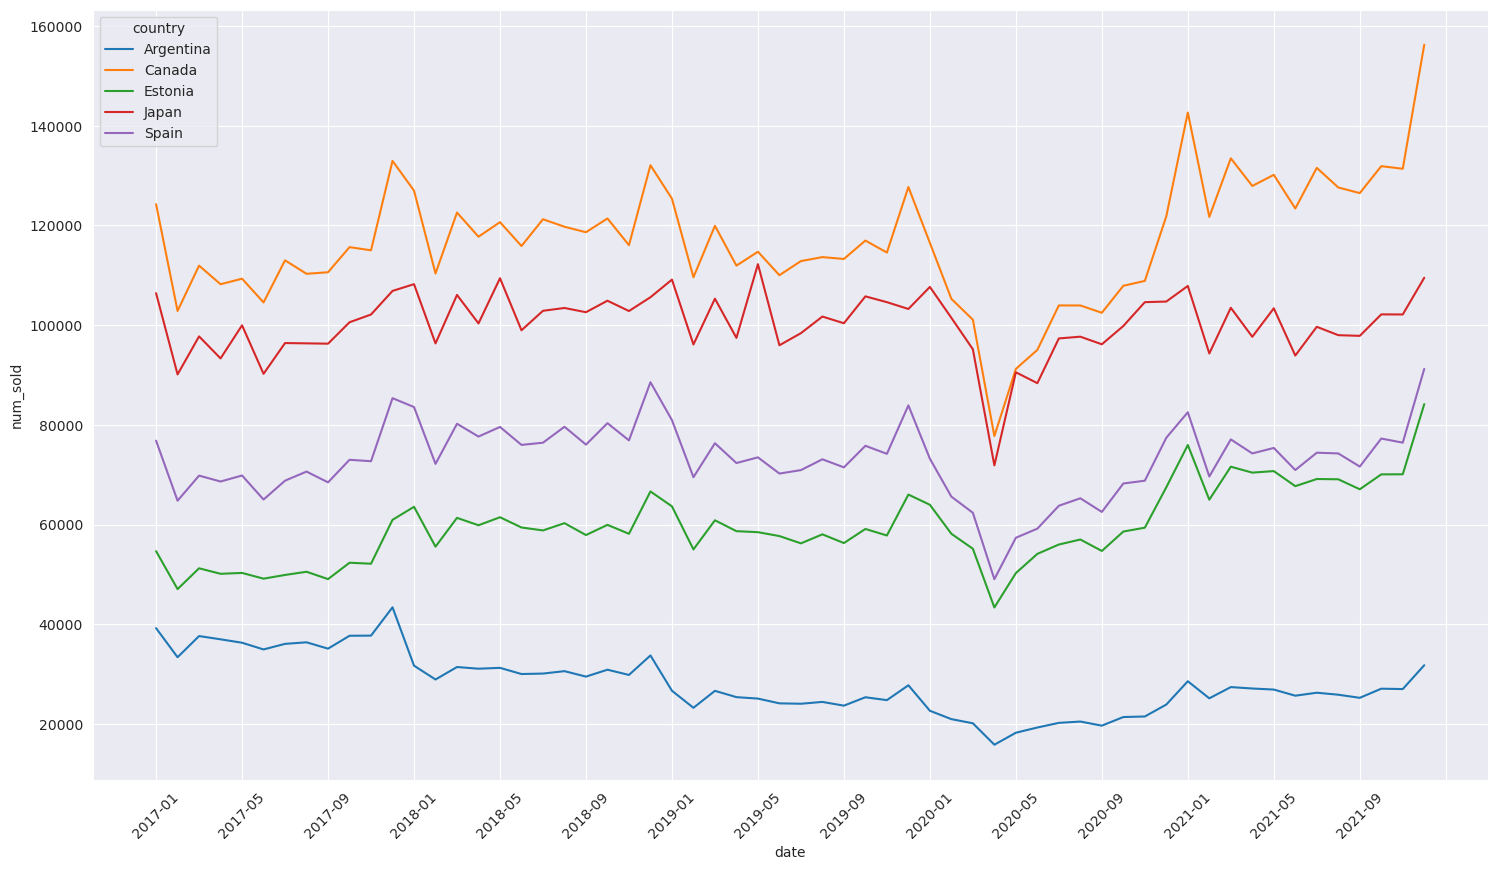

In [10]:
#Each tuple give sale of a  product in a store from a particular country
#We would love to visualise total sale in each country along the year
#Each group is total sales of a particular country in a particular month
plt.figure(figsize=(18,10))
sns.set_style("darkgrid")
ax=sns.lineplot(data=df_train.groupby([df_train.country,df_train.date.dt.strftime('%Y-%m')])['num_sold'].sum().
             reset_index(),x='date',y='num_sold',hue='country')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

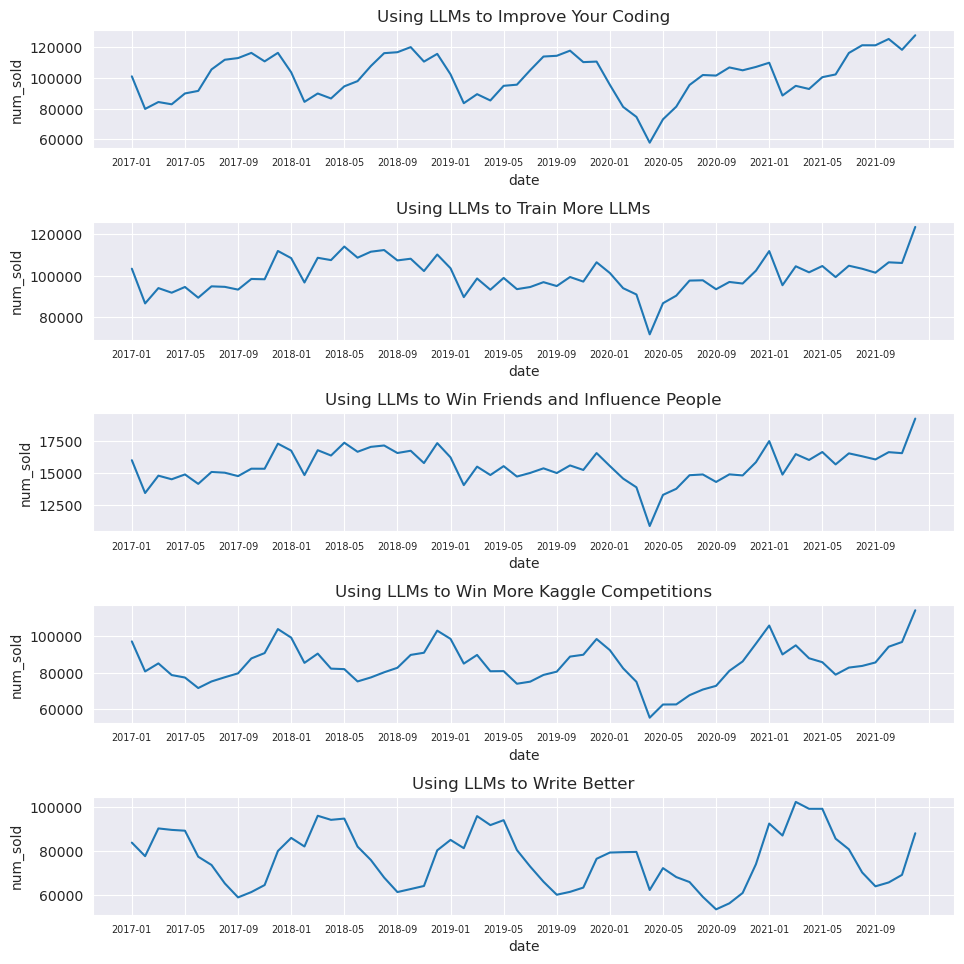

In [11]:
#Visualising sales of each products across the countries for each month
def product_forecast(df):
    gp=df.groupby(['product',df.date.dt.strftime('%Y-%m')])['num_sold'].sum()
    fig,axes=plt.subplots(nrows=df['product'].nunique(),ncols=1,figsize=(10,10))
    ax=axes.flatten()
    for i,x in enumerate(df['product'].unique().tolist()):
        df_product=gp[x,:].to_frame()
        ax[i].set_title(x)
        ax[i]=sns.lineplot(data=df_product,x='date',y='num_sold',ax=ax[i]) 
        ax[i].tick_params(axis='x', labelsize=7)
        ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
    plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1)
    plt.show()
product_forecast(df_train)
#Observing periodicity in the sales of each product.
#Since pandemic is over i we should remove that period.

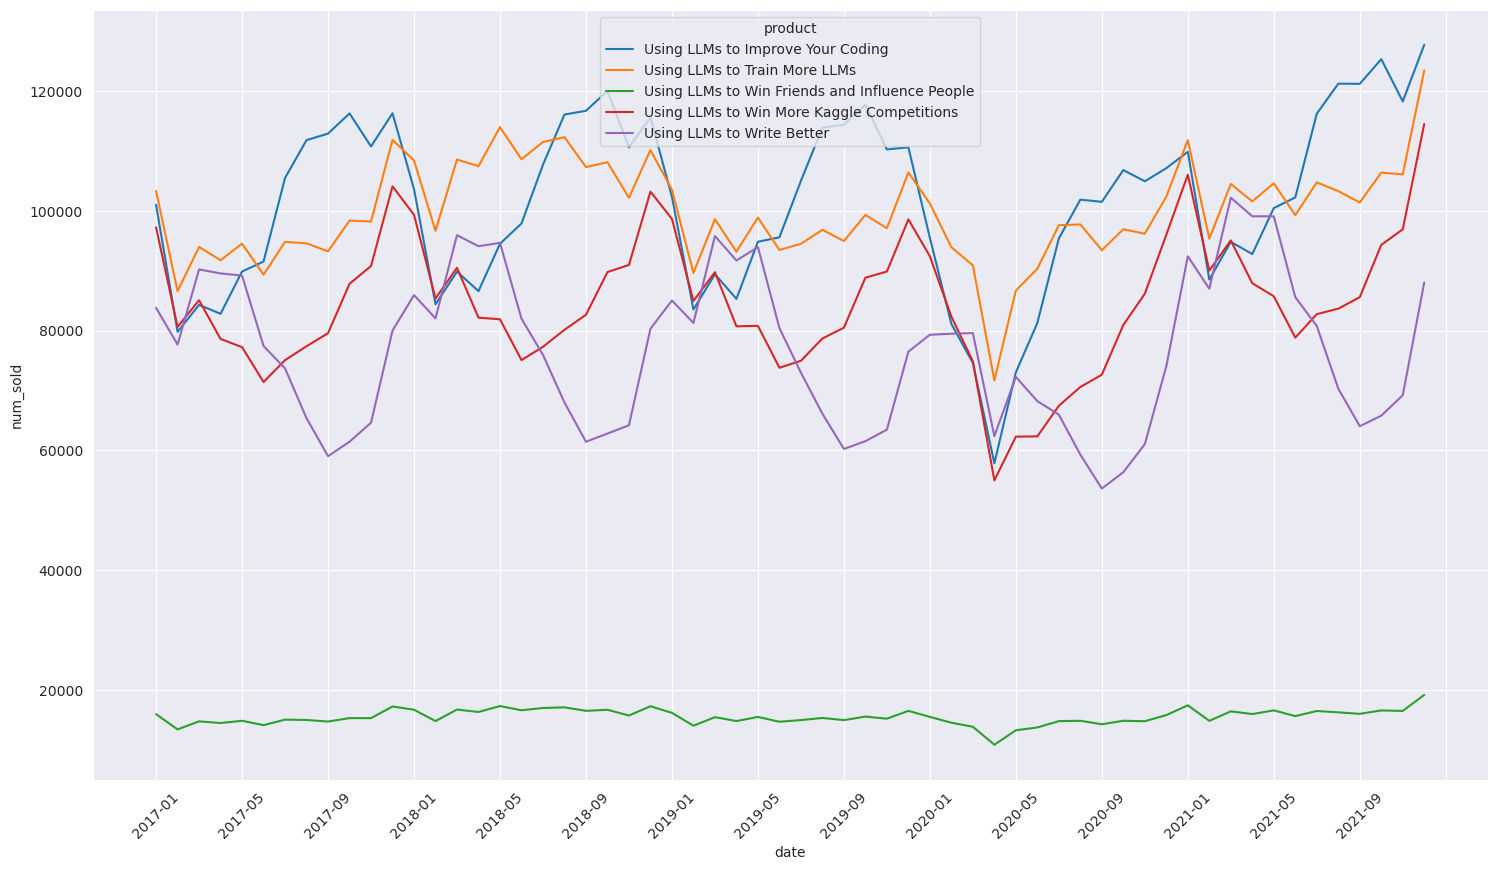

In [12]:
plt.figure(figsize=(18,10))
sns.set_style("darkgrid")
ax=sns.lineplot(data=df_train.groupby(['product',df_train.date.dt.strftime('%Y-%m')])['num_sold'].sum().
             reset_index(),x='date',y='num_sold',hue='product')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

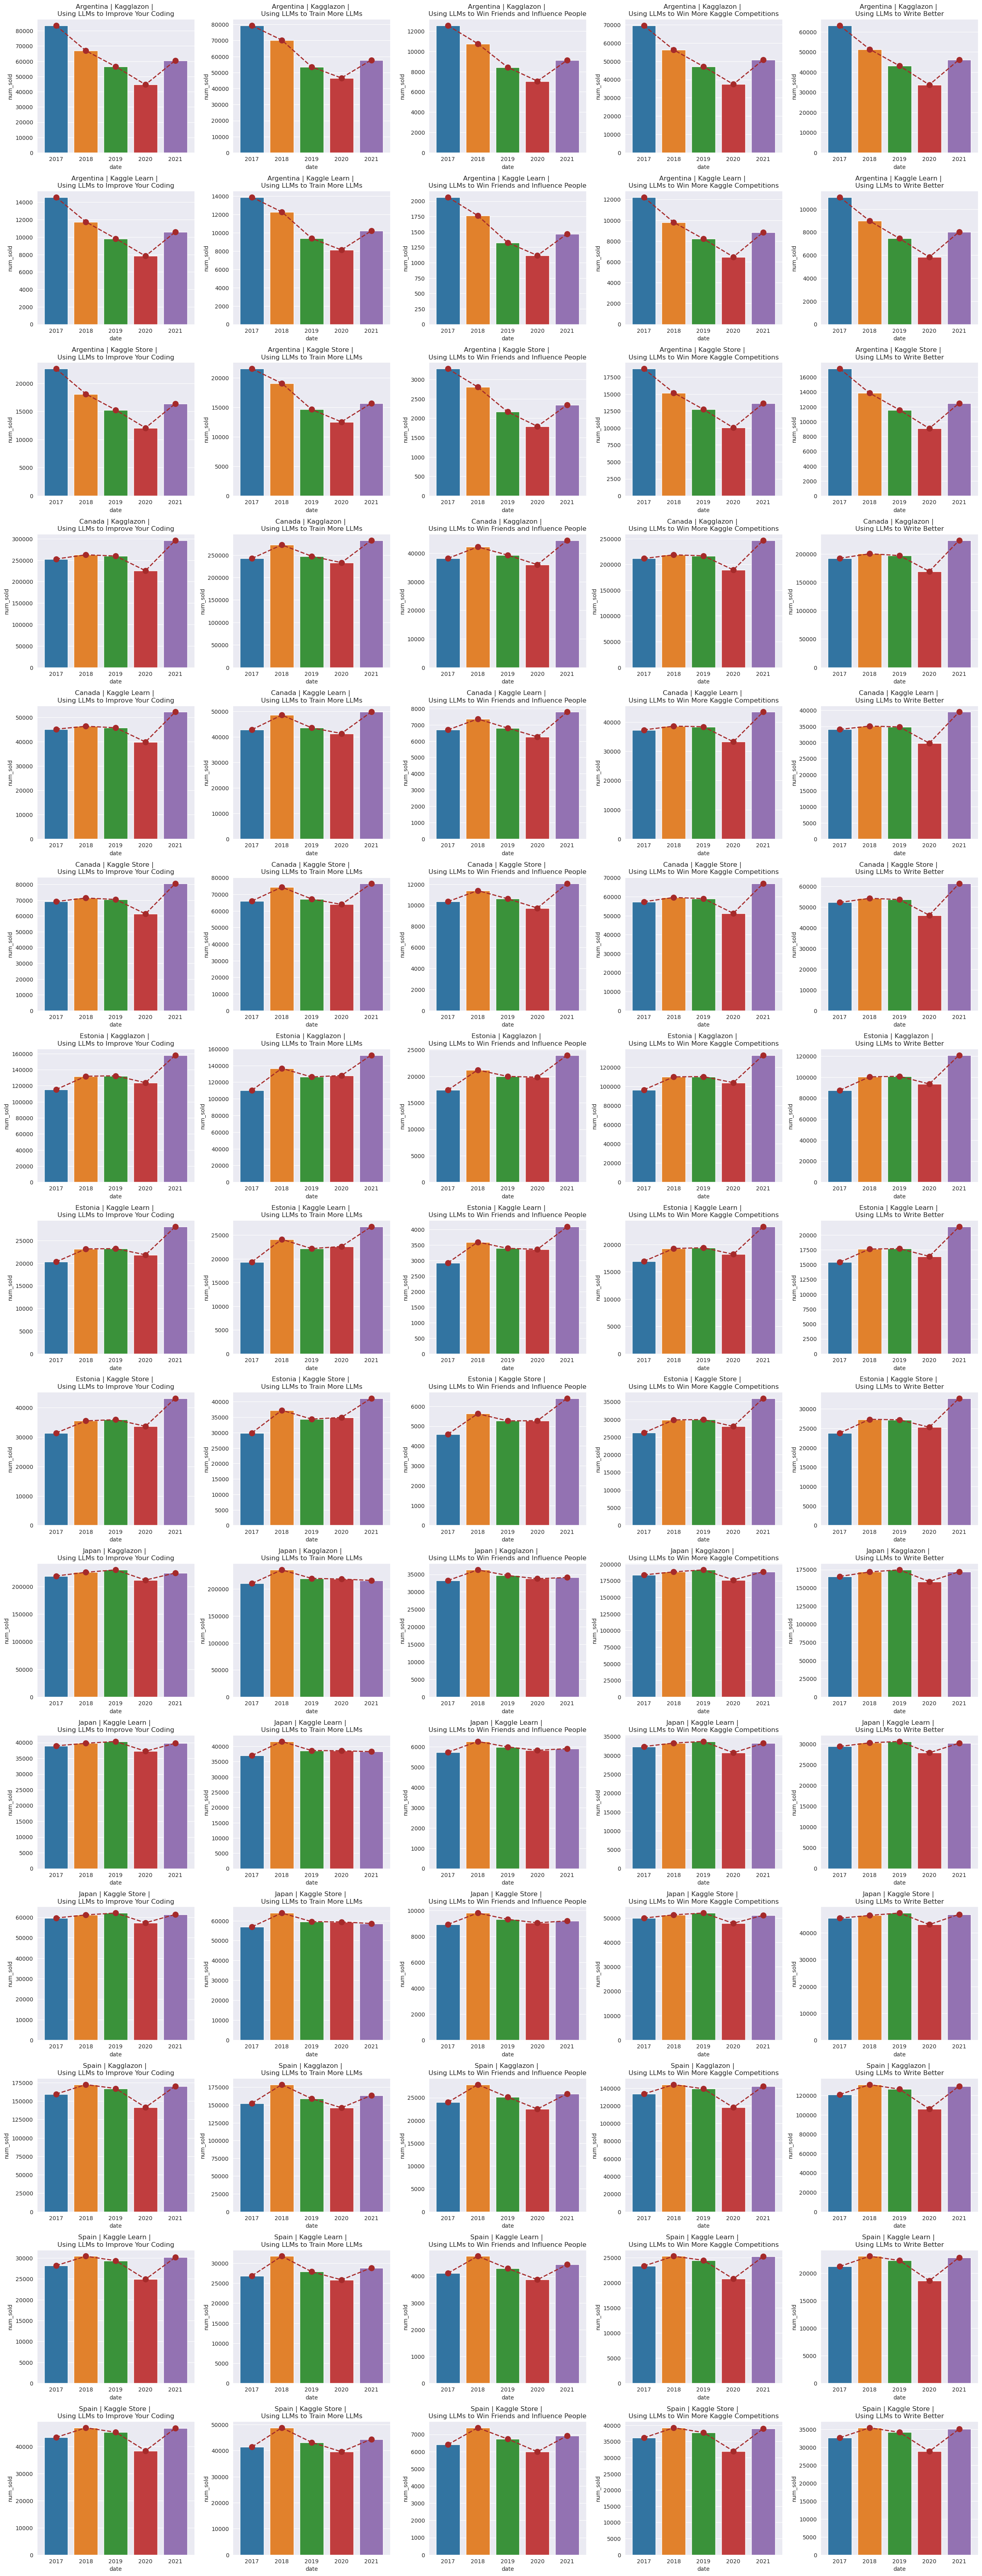

In [13]:
fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()
for i, (combination, df) in enumerate(df_train.groupby(['country', 'store', 'product'])):
    data = df.groupby(df.date.dt.year)['num_sold'].sum().reset_index()
    sns.barplot(data = data, x = 'date', y = 'num_sold', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.num_sold,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])
plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1)

# Trend analysis

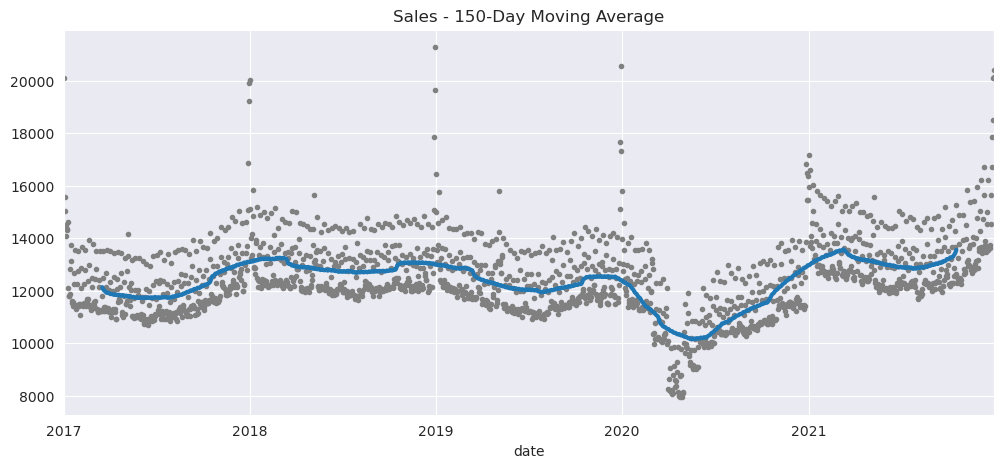

In [14]:
#Trend analysis
plt.figure(figsize=(12,5))
trend=df_train.groupby([df_train.date])['num_sold'].sum()
moving_average = trend.rolling(
    window=150,       
    center=True,     
).mean()             

ax = trend.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Sales - 150-Day Moving Average", legend=False,
);

In [15]:
#we tried to visualise the trend using moving average.I come to the conclusion that a 3rd order
#curve can fit the trend better hence wish to add a feature that would decide in creating a 3rd degree
#curve for model fitting during training.
from statsmodels.tsa.deterministic import DeterministicProcess
df_trend=df_train.groupby([df_train.date])['num_sold'].sum()
dp=DeterministicProcess(index=df_trend.index, order=3,drop=True)
X_trend=dp.in_sample()#These features are supposed to give the curve and they remove normal time dummies
X_forec=dp.out_of_sample(steps=90)

In [16]:
#Adding dates as index for test set.Deterministic process was supposed to give this.
last_date = df_trend.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=90)
X_fore=pd.DataFrame(data=X_forec,index=forecast_dates)
#There was some thing wrong with out_of_sample so that it didnt give dates as index hence had to do this manual
X_fore['trend'] = list(X_forec.iloc[:, 0])
X_fore['trend_squared'] = list(X_forec.iloc[:, 1])
X_fore['trend_cubed'] = list(X_forec.iloc[:, 2])

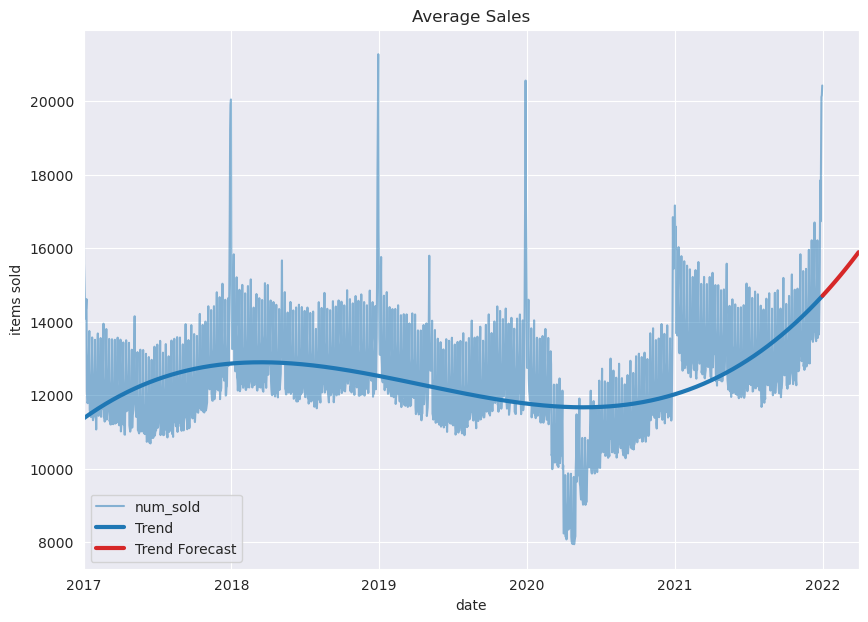

In [17]:
from sklearn.linear_model import LinearRegression
plt.figure(figsize=(10,7))
model = LinearRegression()
#fitting the model using the created feature and actual sales
model.fit(X_trend,df_trend)

#Using the model to predict
#predicting training set()
y_pred = pd.Series(model.predict(X_trend), index=X_trend.index)
#predicting the testing set
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#Checking whether the model can do the fitting and testing visually through plots
ax = df_trend.plot( alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# Seasonal trends

In [18]:
#Checking for seasonal trends
df_season=df_train.groupby([df_train.date])['num_sold'].sum().to_frame()
# days within a week
df_season["day"] = df_season.index.dayofweek  # the x-axis (freq)
df_season["week"] = df_season.index.week  # the seasonal period (period)

# days within a year
df_season["dayofyear"] = df_season.index.dayofyear
df_season["year"] = df_season.index.year

In [19]:
from pathlib import Path
from warnings import simplefilter
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

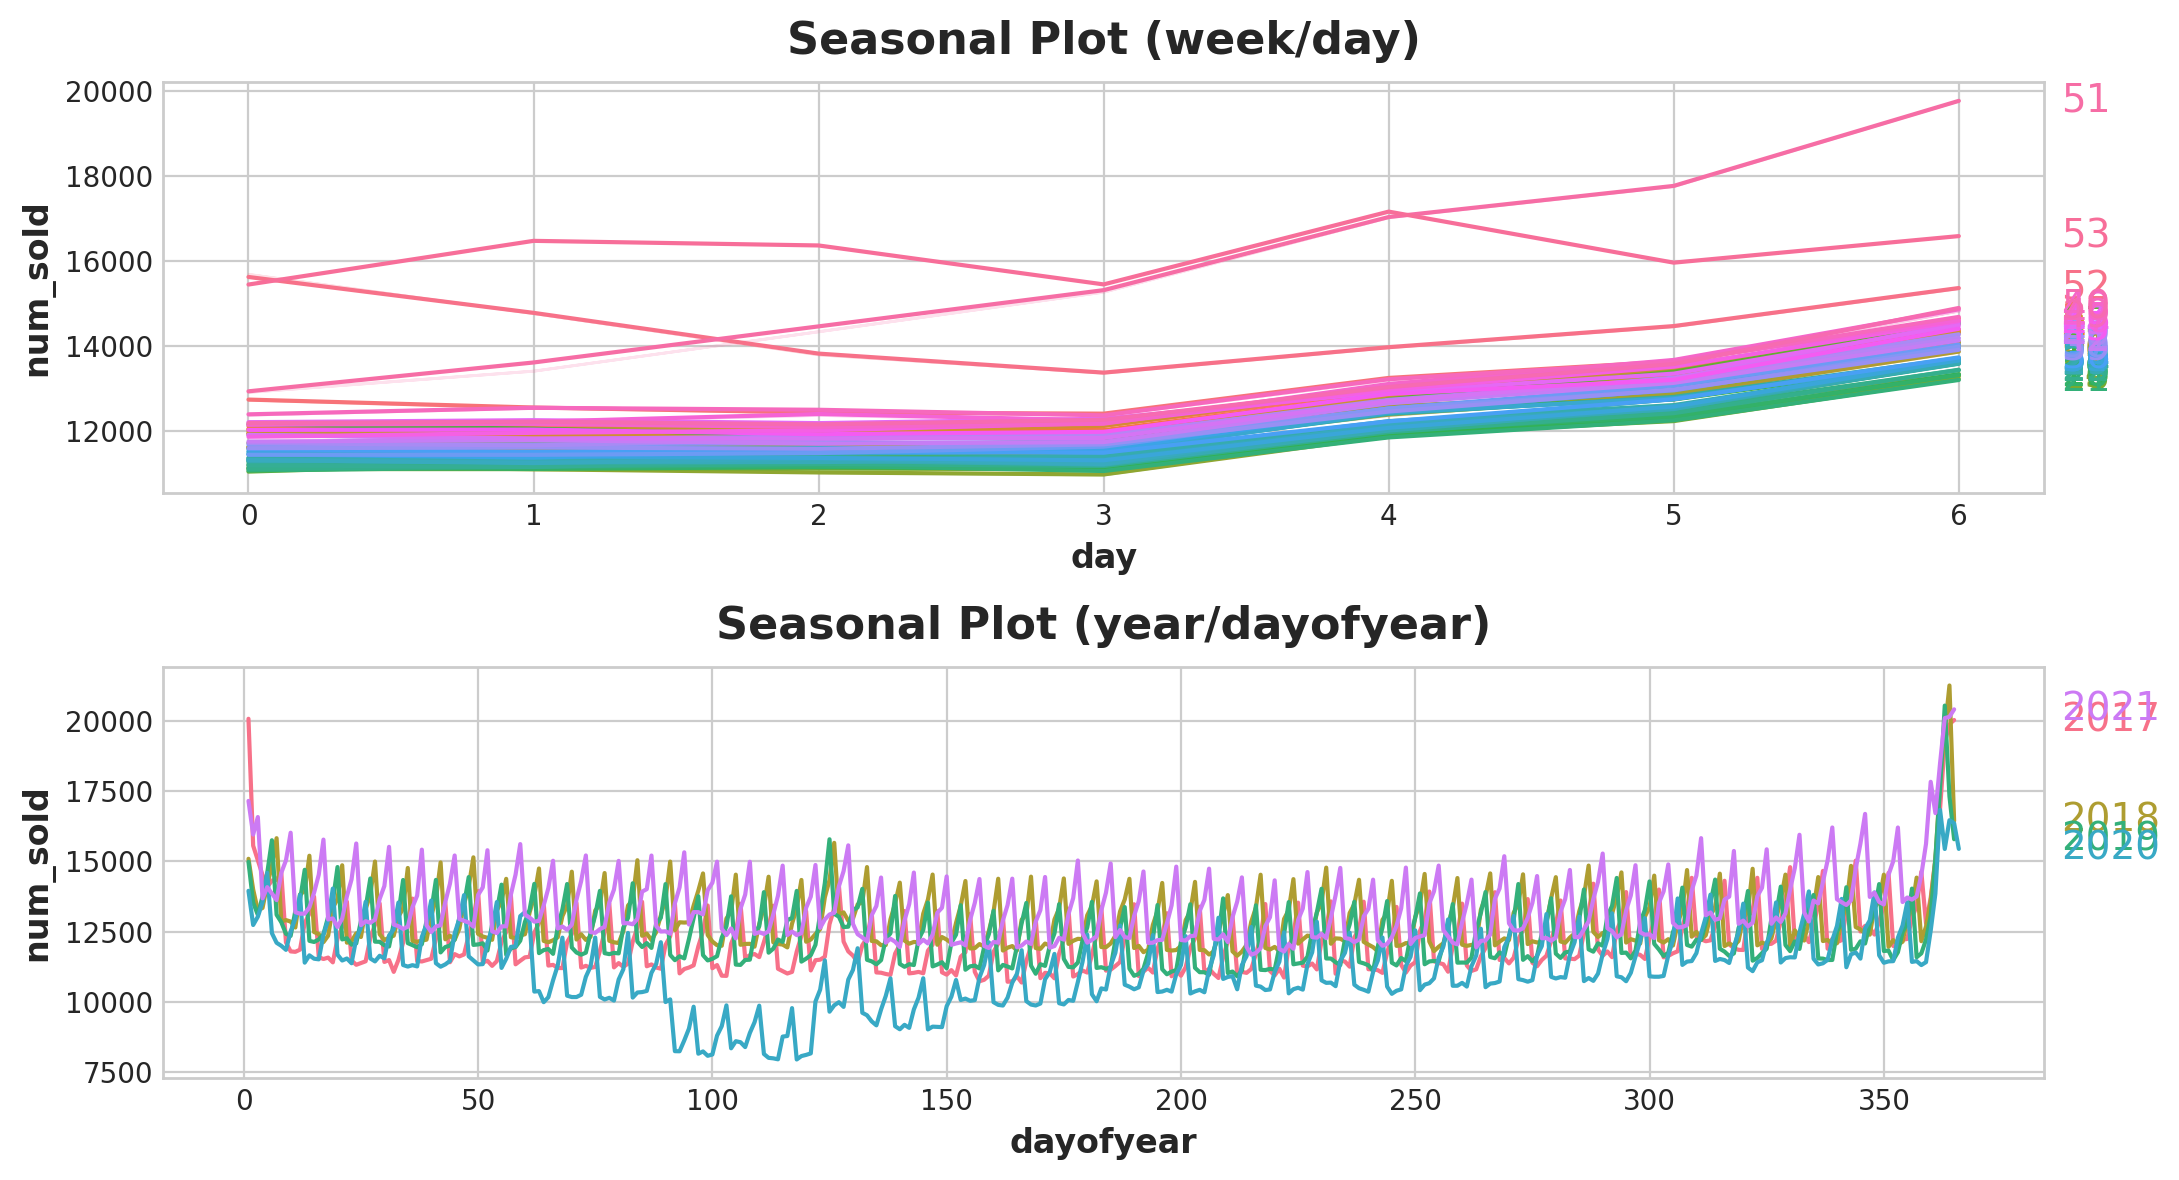

In [20]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(df_season, y="num_sold", period="week", freq="day", ax=ax0)
seasonal_plot(df_season, y="num_sold", period="year", freq="dayofyear", ax=ax1);

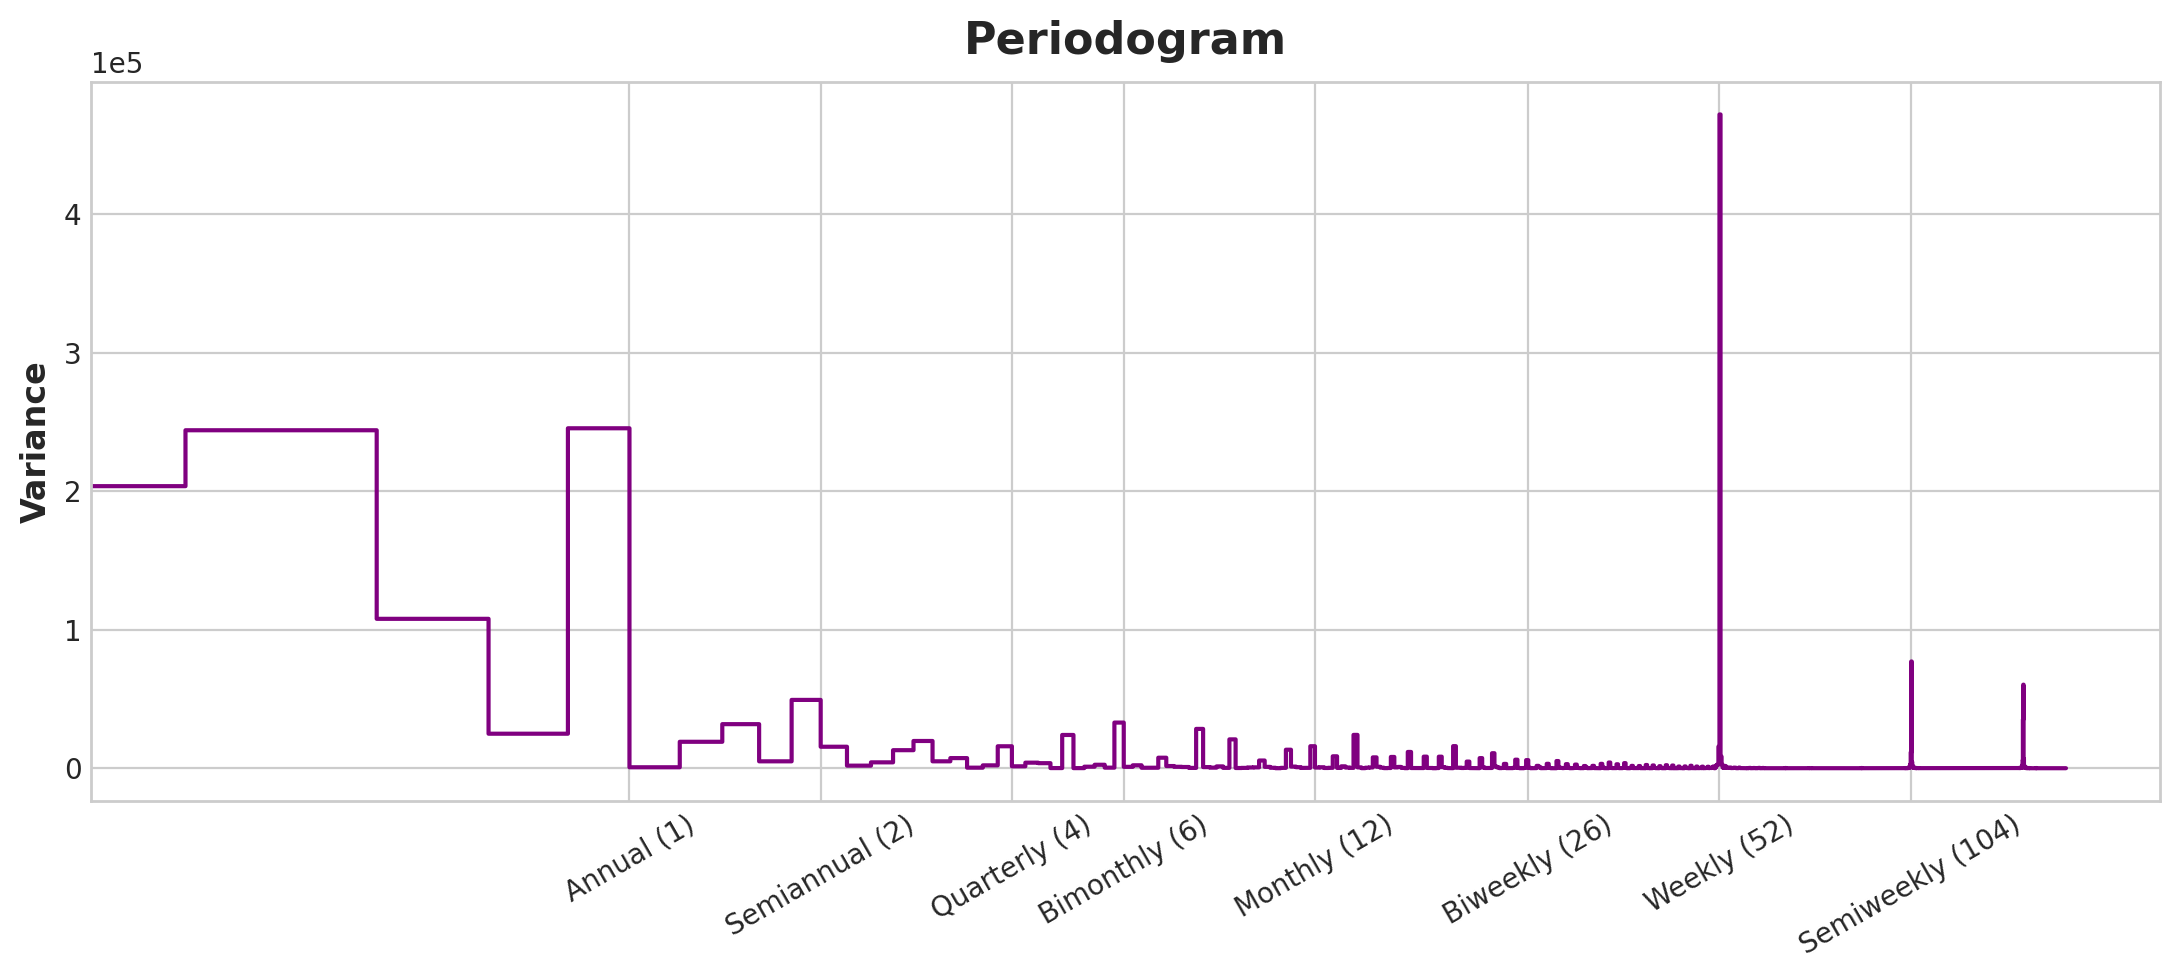

In [21]:
plot_periodogram(df_season.num_sold);
#The periodogram suggest strong weekly season which we observed visually.
#here the periodograms starts to falls off inbetween semiannual and quarterly.There fore we could use
#3 pairs of fourier features.We wont be using all the frequencies as fourier features instead only the 
#the necessay features that could capture the overall seasonality.From the periodograms we can observe
#only annual,semiannual and quarterly got enough weights hence only 3 pairs of fourier features.Weekly 
#seasonality will be added using seasonal inidcators

In [22]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq="A", order=4)  
dp = DeterministicProcess(
    index=df_season.index,
    constant=True,              
    order=1,                     
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   
)
X=dp.in_sample()

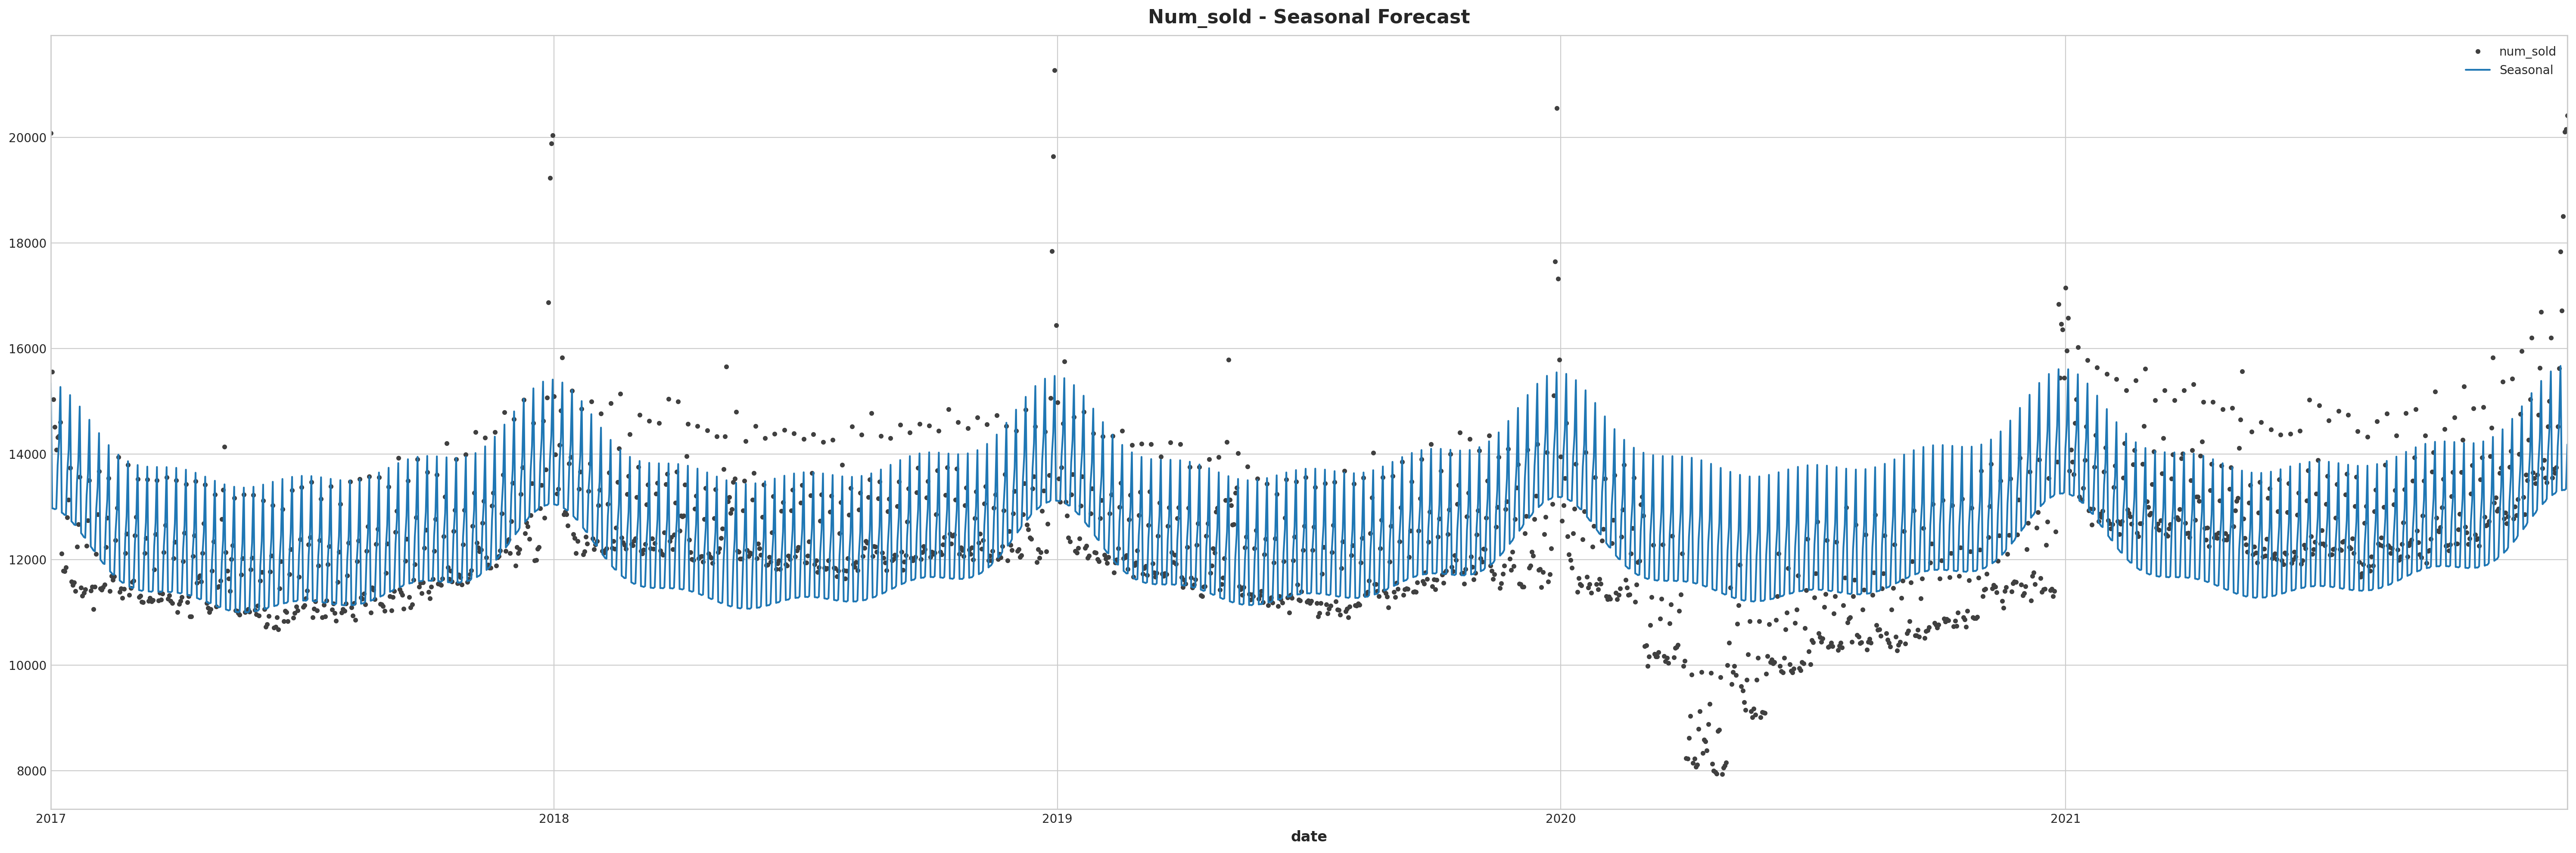

In [23]:
plt.figure(figsize=(30,10))
y = df_season["num_sold"]
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
ax = y.plot(color='0.25', style='.', title="Num_sold - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
_ = ax.legend()

If we look at how our model was able to do the forecasting we can observe that it capture almost everything except the dip in sale during the covid.We should do something for the model to understand that sales went down during the covid.

# serial dependence

In [24]:
#checking for cycles
df_cycles=df_train.groupby([df_train.date])['num_sold'].sum().to_frame()
df_cycles = pd.DataFrame({
    'num_sold': df_cycles['num_sold'],
    'num_sold_lag_1': df_cycles['num_sold'].shift(1),
    'num_sold_lag_2': df_cycles['num_sold'].shift(2),    
})

In [25]:
#serial dependence.
df_serial=df_train.groupby([df_train.date])['num_sold'].sum().to_frame()

In [26]:
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

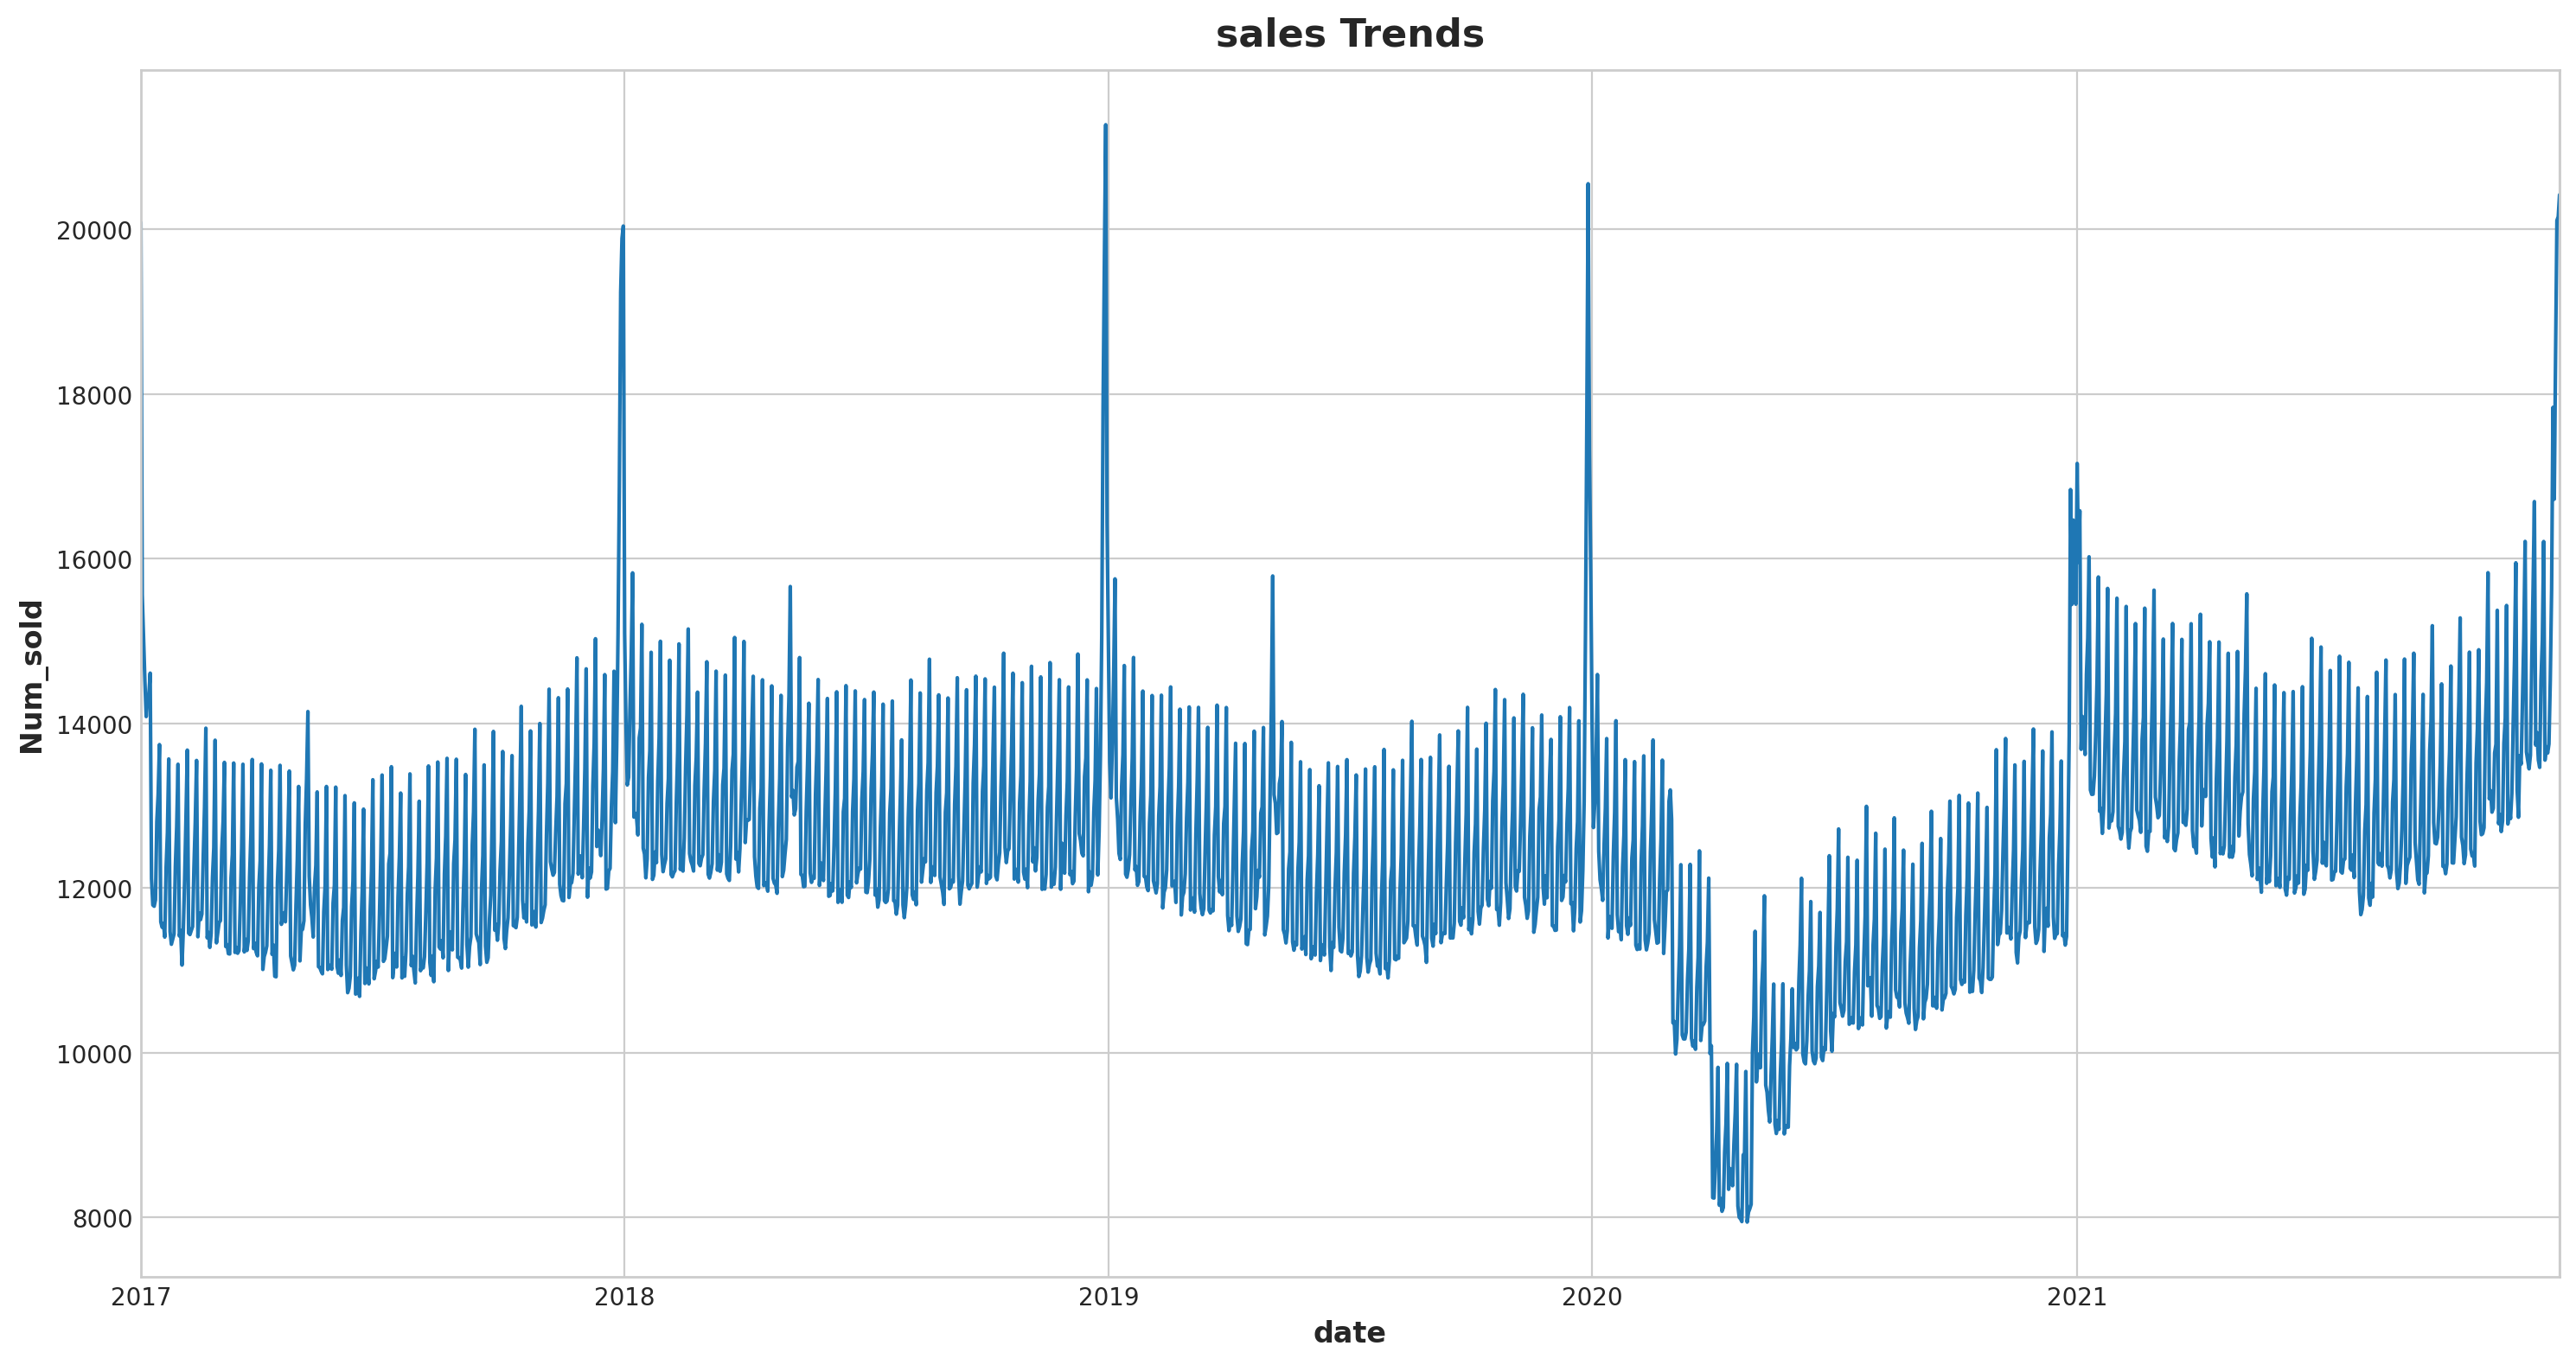

In [27]:
plt.figure(figsize=(15,8))
ax = df_serial.num_sold.plot(title='sales Trends')
_ = ax.set(ylabel="Num_sold")

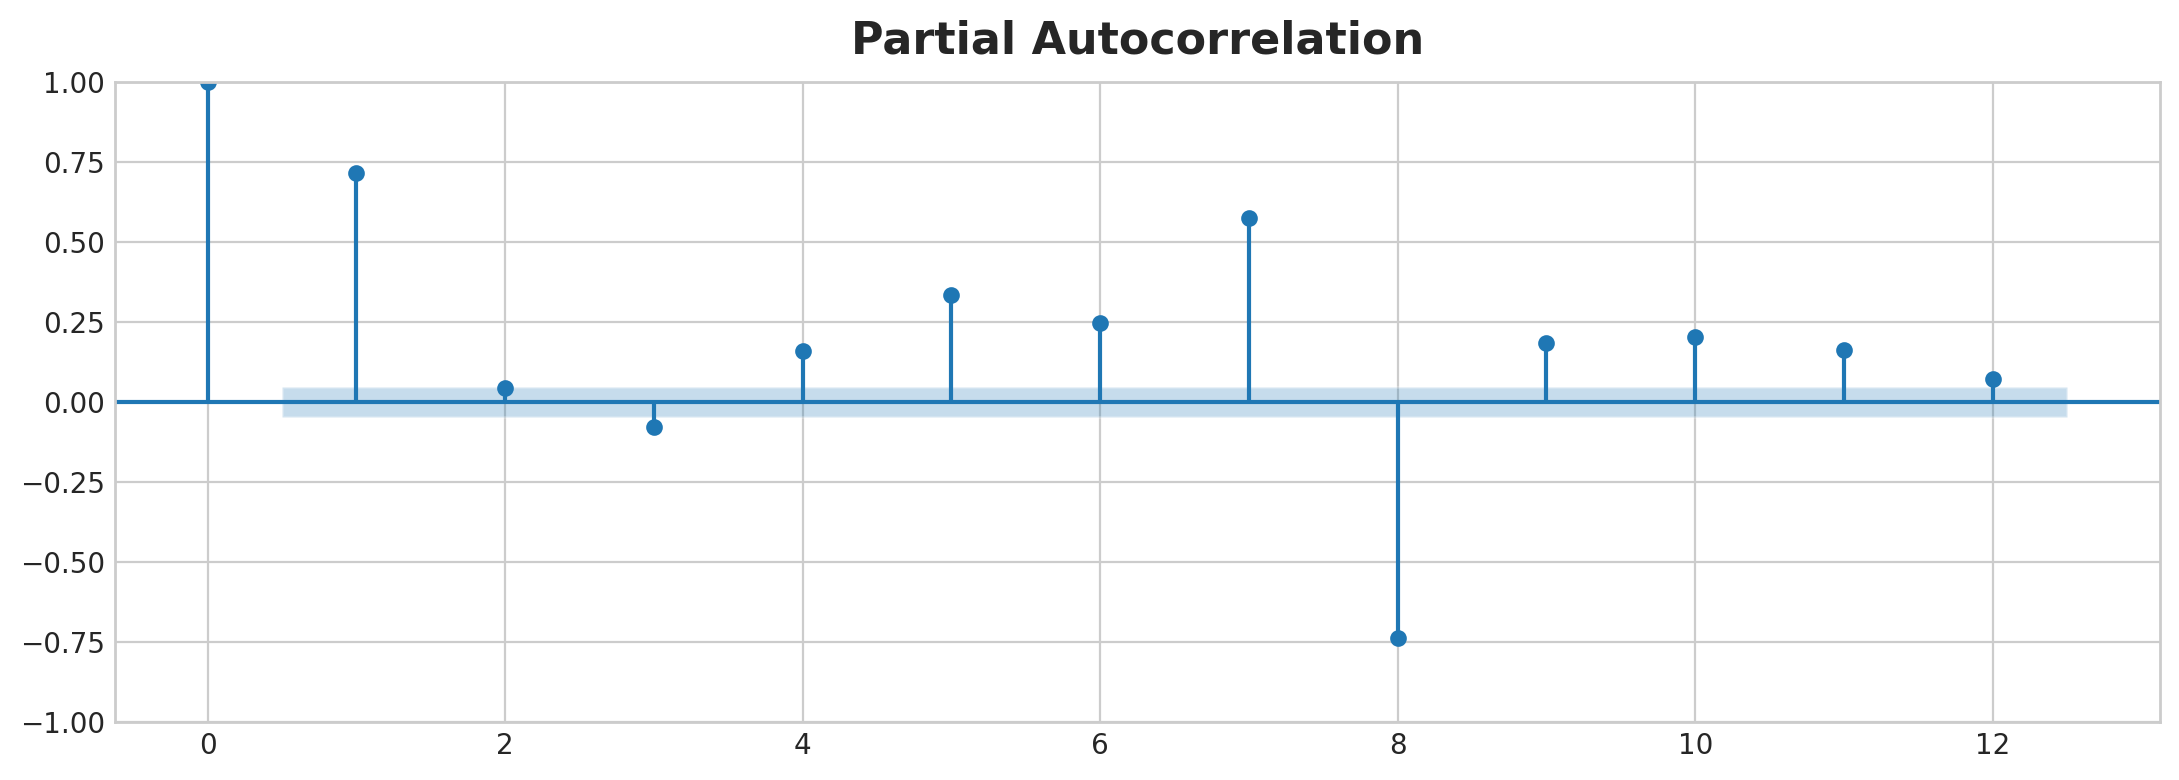

In [28]:
_=plot_pacf(df_serial.num_sold, lags=12)
#the partial autocorrelation tells you the correlation of lag accounting for all the previous lags.

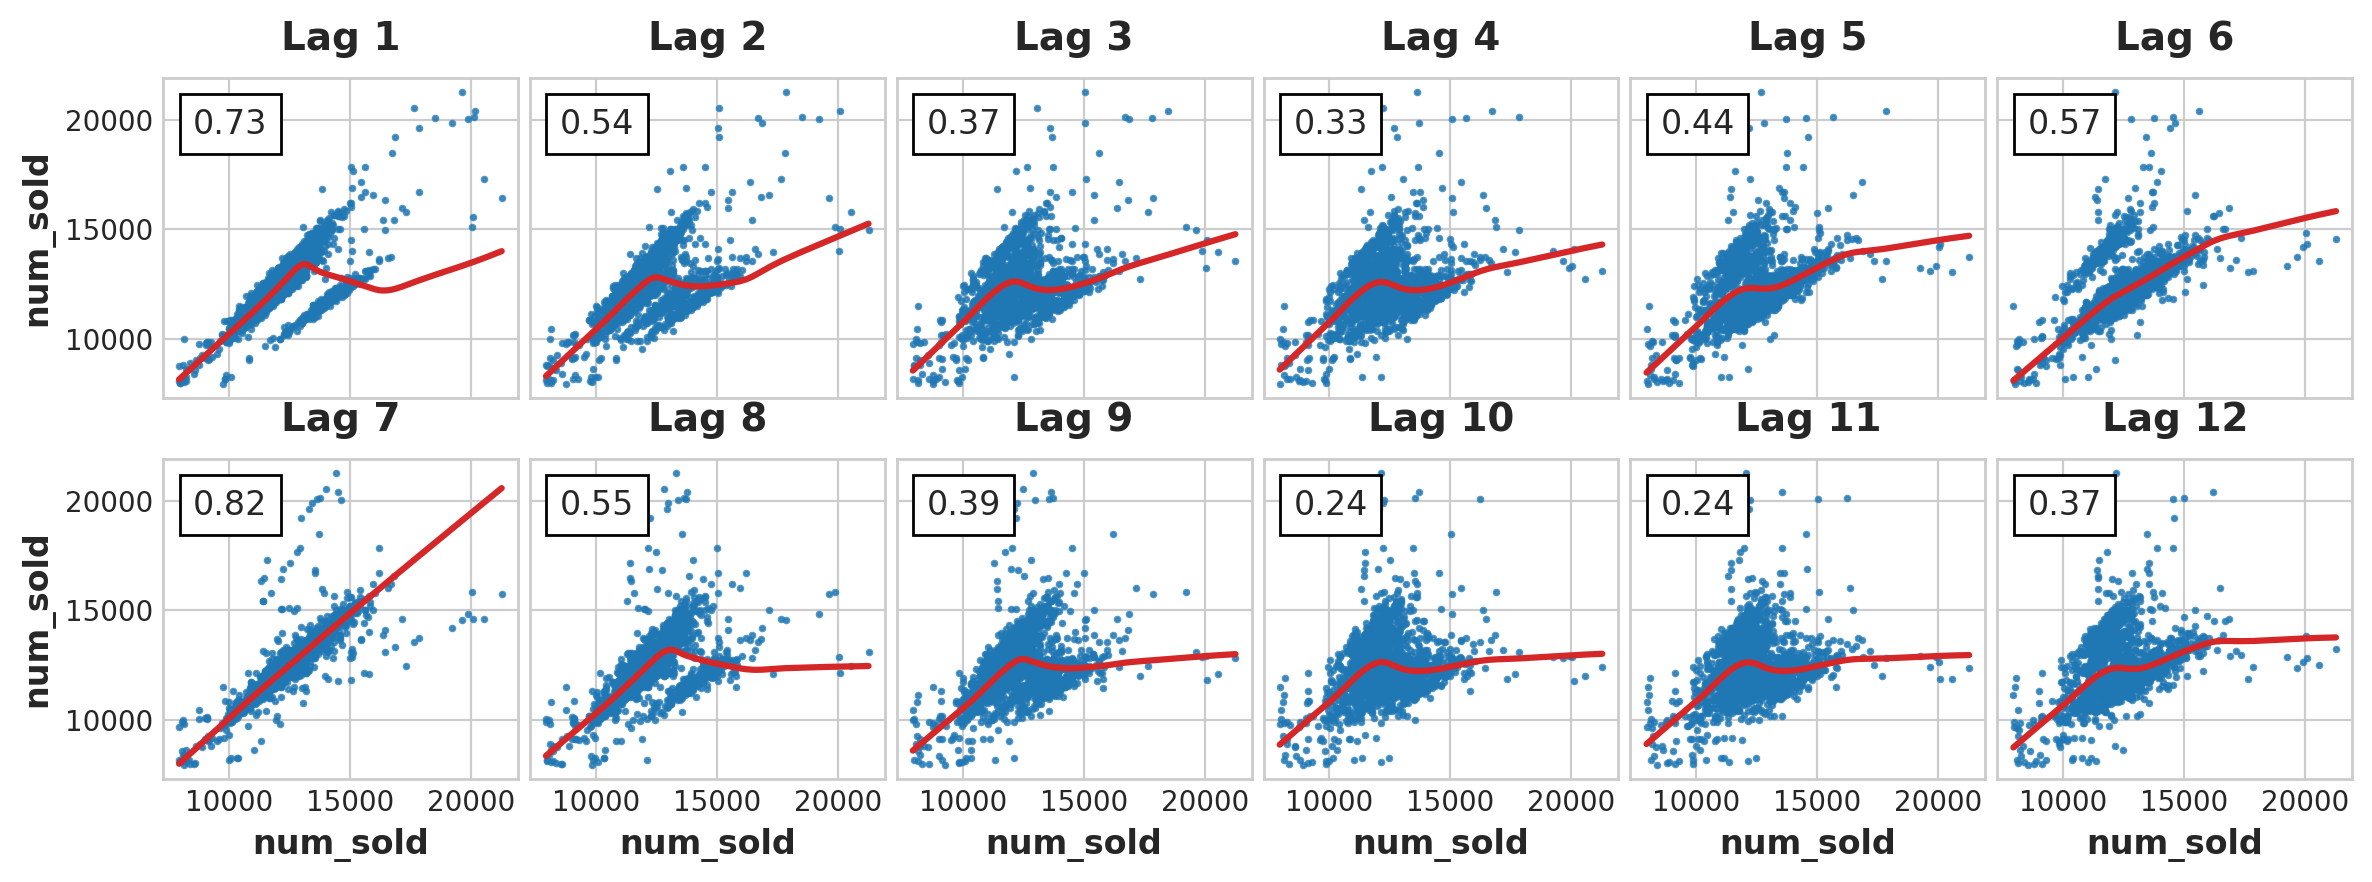

In [29]:
_ = plot_lags(df_serial.num_sold, lags=12, nrows=2)


In [30]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)


X = make_lags(df_serial.num_sold,[1,5,6,7])
X = X.fillna(0.0)

In [31]:
# Create target series and data splits
y = df_serial.num_sold.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

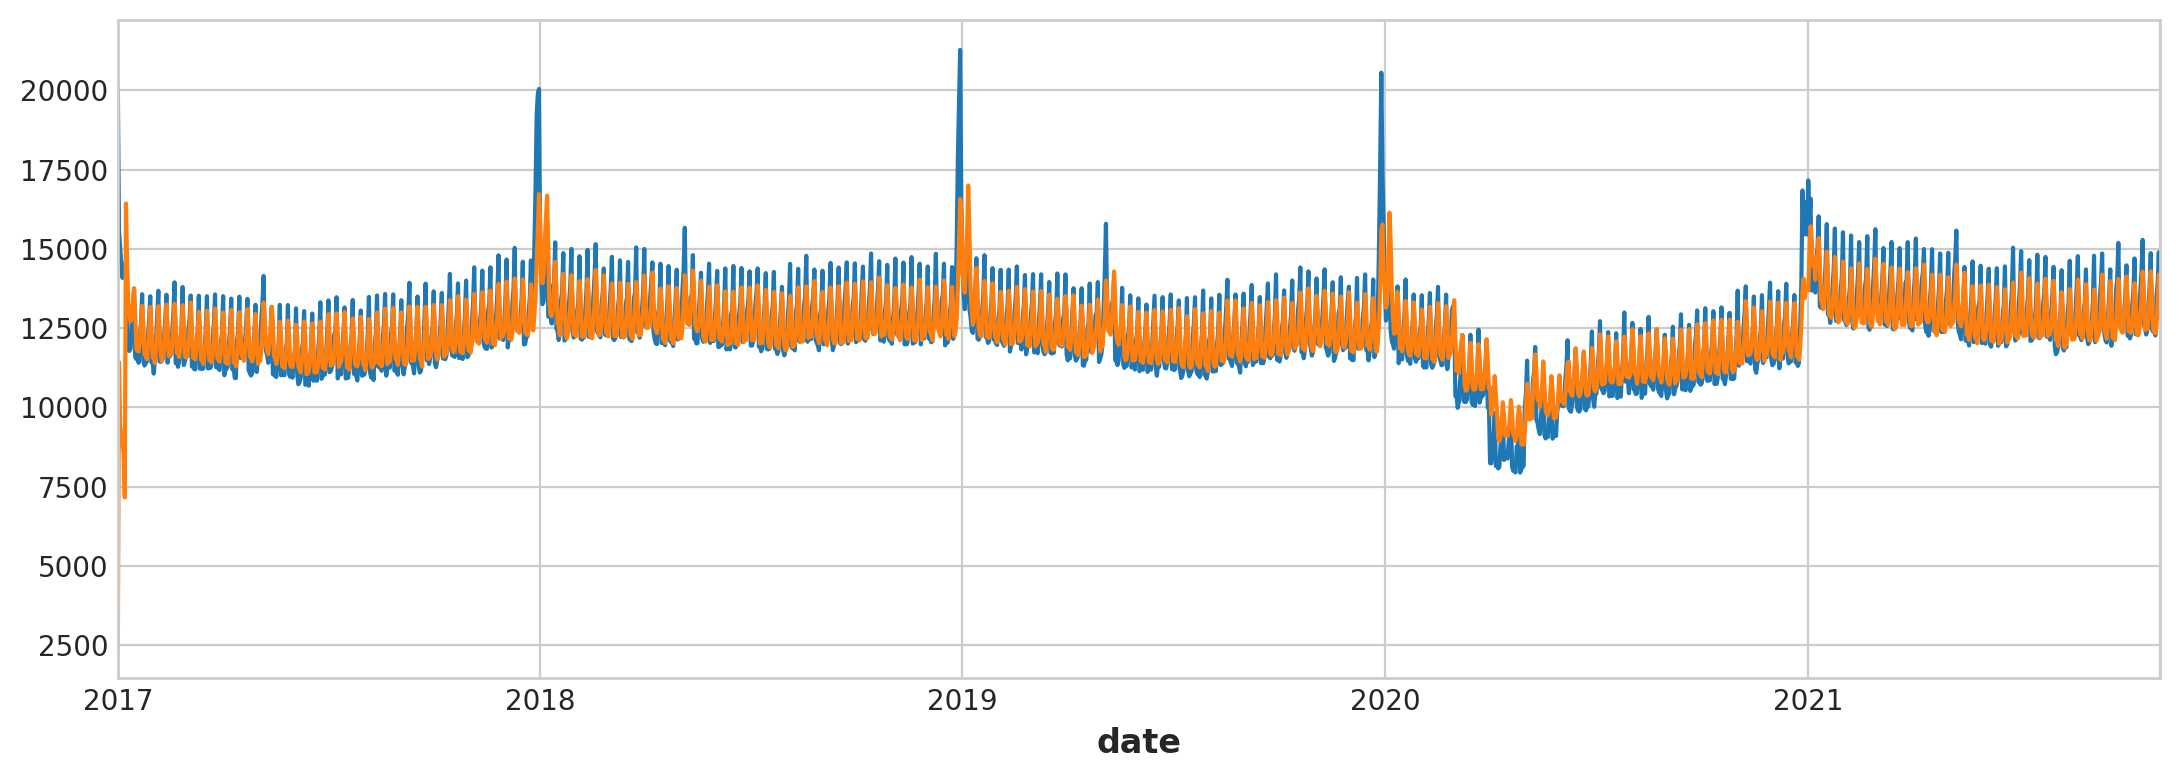

In [32]:
ax = y_train.plot()
ax = y_pred.plot(ax=ax)


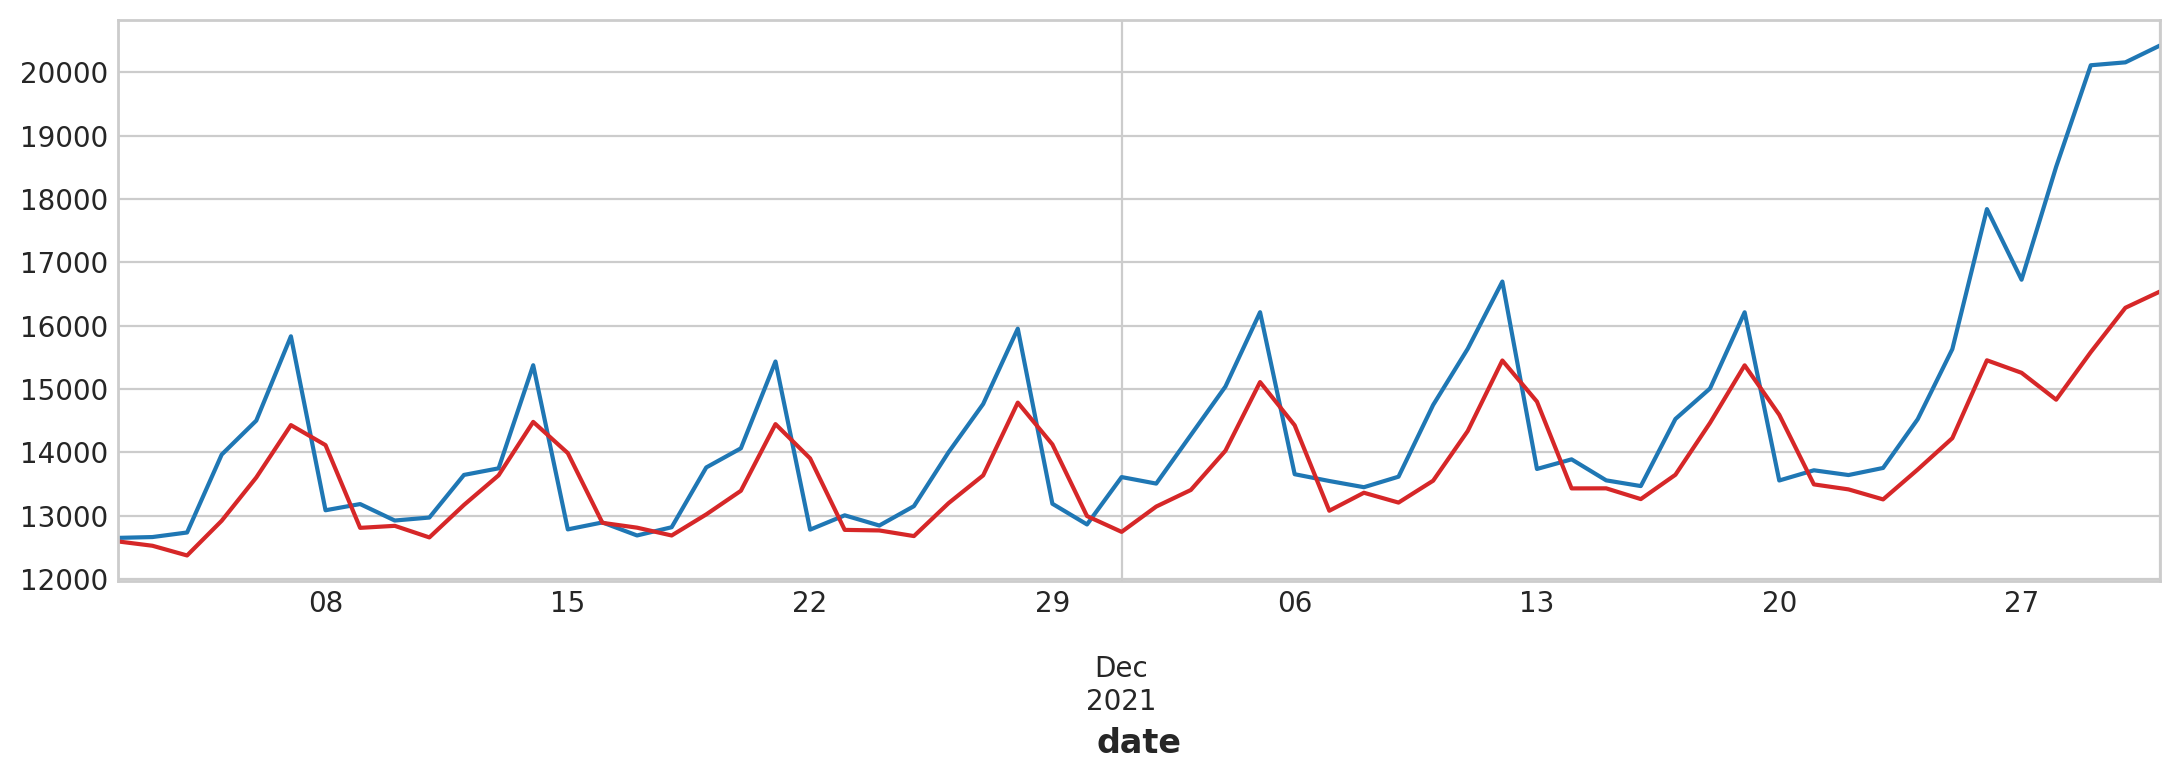

In [33]:
ax = y_test.plot()
_ = y_fore.plot(ax=ax, color='C3')

#  Feature Engineering

In [34]:
#Actually sales on holiday should be zero but this is not considered in the dataset hence we are 
#adding  and extra columns call is holiday.
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years = years_list)
    holiday_CA = holidays.CountryHoliday('CA', years = years_list)
    holiday_ES = holidays.CountryHoliday('EE', years = years_list)
    holiday_JA = holidays.CountryHoliday('JP', years = years_list)
    holiday_SP = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_ES)
    holiday_dict.update(holiday_JA)
    holiday_dict.update(holiday_SP)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    df.drop(columns = 'holiday_name', axis = 1, inplace = True)
    
    return df

def feature_engineer(df):
    new_df = df.copy()
    #Time dummies
    new_df['year']=df['date'].dt.year
    new_df['month'] = df['date'].dt.month
    new_df['month_sin'] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df['month_cos'] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df['day'] =df['date'].dt.day
    new_df['day_sin'] = np.sin(new_df['day'] * (2 * np.pi / 365))
    new_df['day_cos'] = np.cos(new_df['day'] * (2 * np.pi / 365))
    new_df['day_of_week'] = df['date'].dt.dayofweek
    
    #We have seen anomaly in sales during covid and we want the machine to capture it.So we are adding
    # a new column
    new_df['day_of_year'] = df['date'].dt.dayofyear
    new_df['covid_day'] = new_df.apply(lambda x: 0 if (x['date'] >pd.Timestamp
    ('2020-02-29')and x['date'] < pd.Timestamp('2021-01-01'))  else 1, axis = 1)
    new_df = pd.get_dummies(new_df, columns = ['country'], drop_first = True)
    new_df = pd.get_dummies(new_df, columns = ['store'], drop_first = True)
    new_df = pd.get_dummies(new_df, columns = ['product'], drop_first = True)
    
    return new_df


df_train = get_holidays(df_train)
df_train = feature_engineer(df_train)

df_test = get_holidays(df_test)
df_test = feature_engineer(df_test)

In [35]:
X = df_train.drop(columns = ['id', 'date', 'num_sold'], axis = 1)
Y = df_train['num_sold']
test_baseline = df_test.drop(columns = ['id', 'date'], axis = 1)

In [36]:
from sklearn.model_selection import  train_test_split,RepeatedStratifiedKFold, GroupKFold

In [37]:
kf = GroupKFold(n_splits = 5)
linear_preds, linear_smape = list(), list()
for i, (trn_idx, test_idx) in enumerate(kf.split(X, groups = X.year)):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    y_train = np.log(y_train)
    y_valid = np.log(y_valid)
    
    print('---------------------------------------------------------------')
    
    ##################
    ## Linear model ##
    ##################
    
    # linear_model = make_pipeline(StandardScaler(), LinearRegression()).fit(x_train, y_train)
    linear_model = LinearRegression().fit(x_train, y_train)

    linear_y_pred = np.exp(linear_model.predict(x_valid))
    linear_smape_oof = smape(np.exp(y_valid), linear_y_pred) 
    
    print('Fold', i, '==> Linear oof SMAPE is ==>', linear_smape_oof)

    linear_smape.append(linear_smape_oof)
    linear_pred = np.exp(linear_model.predict(test_baseline))
    linear_preds.append(linear_pred)

---------------------------------------------------------------
Fold 0 ==> Linear oof SMAPE is ==> 19.819024462697186
---------------------------------------------------------------
Fold 1 ==> Linear oof SMAPE is ==> 14.719157264745025
---------------------------------------------------------------
Fold 2 ==> Linear oof SMAPE is ==> 11.944634850779577
---------------------------------------------------------------
Fold 3 ==> Linear oof SMAPE is ==> 11.79622262385788
---------------------------------------------------------------
Fold 4 ==> Linear oof SMAPE is ==> 17.847464620853838


In [38]:
num_sold=pd.DataFrame(np.mean(linear_preds,axis=0))

In [39]:
df_submission['num_sold'] = round(num_sold).astype(int)

In [40]:
df_submission.to_csv('submission.csv')